In [1]:
'''
This code imports numpy packages and allows us to pass data from python to global javascript
objects. It was developed by znah@github
'''

import json
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import HTML, Javascript, display

def json_numpy_serializer(o):
    if isinstance(o, np.ndarray):
        return o.tolist()
    raise TypeError("{} of type {} is not JSON serializable".format(repr(o), type(o)))

def jsglobal(**params):
    code = [];
    for name, value in params.items():
        jsdata = json.dumps(value, default=json_numpy_serializer)
        code.append("window.{}={};".format(name, jsdata))
    display(Javascript("\n".join(code)))

In [2]:
%%javascript

// Loading the compiled MathBox bundle.
require.config({
    //baseUrl:'', paths: { mathBox: '../../tree/static/mathbox/build/mathbox-bundle', graphing: '../../tree/static/graphing/graphing'}
    // online compilation
    baseUrl: '', paths: {mathBox: '../static/mathbox/build/mathbox-bundle', graphing: '../../static/graphing/graphing'}
    // online compilation without local library-- remove baseUrl
    //paths: {mathBox: '//cdn.rawgit.com/unconed/mathbox/eaeb8e15/build/mathbox-bundle'}
});

// Require commands for 3d plotting
require(['graphing'])

<IPython.core.display.Javascript object>

# Part IX: Stochastic Gradient Descent

We now return to the example of logistic regression, but where we now use two parameters in our model. In particular, we will set

$$
\text{prob}(y=1\vert x;\beta_0, \beta_1) = \text{logit}(\beta_1 x +\beta_0)
$$
and
$$
\text{prob}(y=-1\vert x;\beta_0, \beta_1) = \text{logit}(-\beta_1 x - \beta_0)
$$


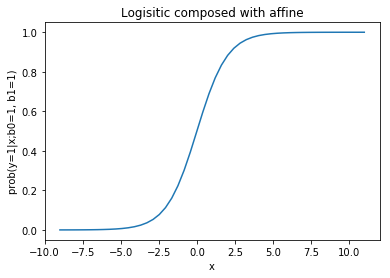

In [3]:
def logit(x):
    return 1/(1+np.exp(-x))

b0 = 1
b1 = 1

t = np.linspace(-10, 10)
s = b1 * t + b0
plt.plot(s, logit(s))
plt.title('Logisitic composed with affine')
plt.xlabel('x')
plt.ylabel('prob(y=1|x;b0=' + str(b0) + ', b1=' + str(b1) + ')')
plt.show()

Now suppose we are supplied with data $\{(x^{(i)}, y^{(i)})\}_{i=1}^N\subset\mathbb{R}\times\{-1, 1\}$, where we assume that $x^{(i)}$ are chosen by some arbitrary process and $y^{(i)}$ is drawn from a Bernoulli trial with the above probability of $y^{(i)}=1, -1$. Our goal is to use this data to infer the true values of $\beta_0$ and $\beta_1$. Setting

$$
{\bf \beta} = \begin{pmatrix}
\beta_0\\
\beta_1
\end{pmatrix}\text{ and } {\bf x} = \begin{pmatrix}
1\\
x
\end{pmatrix},
$$

$\text{logit}(\beta_1 x + \beta_0)=\text{logit}({\bf \beta}^T{\bf x})$. The maximum likelihood principle leads us to consider the maximization of the likelihood

$$
\mathcal{L}({\bf \beta}) = \prod_{i=1}^N \text{logit}(y^{(i)}{\bf \beta}^T {\bf x}^{(i)})
$$

and we therefore seek the minimize the negative log-likelihood

$$
\ell({\bf \beta}) = \frac{1}{N} \sum_{i=1}^N \log\left(1 + e^{-y^{(i)}{\bf \beta}^T {\bf x}^{(i)}}\right)
$$

Let's create some data to display this function


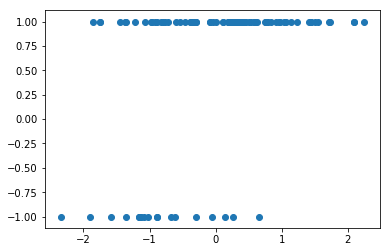

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
N = 100
beta = np.array([2, 2]) # The true parameters in the model
x = rd.randn(N) # Arbitrary x values

# y's drawn randomly
y = np.zeros(N)
for i in range(N):
    if rd.binomial(1,logit(beta.T @ [1, x[i]])) == 1:
        y[i] = 1
    else:
        y[i] = -1
        
plt.scatter(x, y)
plt.show()
        
jsglobal(X=x)
jsglobal(Y=y)
jsglobal(B=beta)

In [5]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(b0, b1) {
        
        var val = 0;
        for (var i = 0; i<X.length; i++) {
            val = val + Math.log(1 + Math.exp(-Y[i] * (b1 * X[i] + b0)));
        } 
        
        return val / X.length;
    }
    
    var view = plotGraph(mathbox, fcn, 'b0', 'b1', 'l(b0,b1)', [[-3, 3], [-1, 3], [-3, 3]]);
    
    addPoint(view, [B[0], B[1], 0], 0x3090FF, '(2, 2)');
    
    addPoint(view, [B[0], B[1], fcn(B[0], B[1])], 0xFF9030, 'Objective at True Parameter')
     
})

<IPython.core.display.Javascript object>

We can generate data and view the objective function determined by that data. We can also illustrate the convergence of stochastic gradient descent.

In [6]:
X_data = np.vstack([np.ones(N), x])
y_data = y

M = 10 # Number of indices to randomly select for each step

def dNLL(beta, X, y):
    return -X @ (y * logit(-beta.T @ X)) / M

iterations = 100

betas_sgd = np.zeros((iterations, 3))

for i in range(1,iterations):
    idxs = rd.choice(N, M, replace=False)
    betas_sgd[i,:2] = betas_sgd[i-1,:2] - np.sqrt(M)*dNLL(betas_sgd[i-1,:2].T, X_data[:,idxs], y_data[idxs])/i

jsglobal(SGD=betas_sgd)

<IPython.core.display.Javascript object>

In [7]:
%%javascript

with_mathbox(element, function(mathbox) {
    
    var fcn = function(b0, b1) {
        
        var val = 0;
        for (var i = 0; i<X.length; i++) {
            val = val + Math.log(1 + Math.exp(-Y[i] * (b1 * X[i] + b0)));
        } 
        
        return val / X.length;
    }
    
    var view = plotGraph(mathbox, fcn, 'b0', 'b1', 'l(b0,b1)', [[-3, 3], [-1, 3], [-3, 3]]);
    
    addPoint(view, [B[0], B[1], 0], 0x3090FF, '(2, 2)');
    
    addPoint(view, [B[0], B[1], fcn(B[0], B[1])], 0xFF9030, 'Objective at True Parameter');
    
    addSequence(view, SGD, 0xFF0000);
     
})

<IPython.core.display.Javascript object>